In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import numpy as np
import sncosmo
import yaml
from astropy.table import Table, vstack
from matplotlib import pyplot as plt

sys.path.insert(0, '..')
from phot_class.utils import parse_config_dict
from sndata.sdss import sako18


In [2]:
def create_empty_table(parameters, **kwargs):
    """Create an empty table for storing fit results

    Columns:
        - obj_id
        - band
        - source
        - pre_max
        - post_max
        - params
        - *parameters
        - *parameters + _err
        - chisq
        - ndof
        - b_max
        - delta_15
        - message

    Args:
        parameters (iter): List of parameter names to add columns for
        Any arguments to pass ``astropy.Table``

    Returns:
        A masked astropy Table
    """

    # Specify column names
    names = ['obj_id', 'band', 'source', 'pre_max', 'post_max', 'params']
    names += list(parameters) + [param + '_err' for param in parameters]
    names += ['chisq', 'ndof', 'b_max', 'delta_15', 'message']

    # Specify column data types
    dtype = ['U20', 'U100', 'U100', int, int, 'U100']
    dtype += [float for _ in range(2 * len(parameters))]
    dtype += [float, float, float, float, 'U10000']

    # Unless otherwise specified, we default to returning a masked table
    kwargs = deepcopy(kwargs)
    kwargs.setdefault('masked', True)
    return Table(names=names, dtype=dtype, **kwargs)


def calc_model_chisq(data, result, model):
    """Calculate the chi-squared for a given data table and model

    Chi-squared is calculated using parameter values from ``model``. Degrees
    of freedom are calculated using the number of varied parameters specified
    is the ``result`` object.

    Args:
        data    (Table): An sncosmo input table
        model   (Model): An sncosmo Model
        result (Result): sncosmo fitting result

    Returns:
        The un-normalized chi-squared
        The number of data points used in the calculation
    """

    data = deepcopy(data)

    # Drop any data that is not withing the model's range
    min_band_wave = [sncosmo.get_bandpass(b).minwave() for b in data['band']]
    max_band_wave = [sncosmo.get_bandpass(b).maxwave() for b in data['band']]
    data = data[
        (data['time'] >= model.mintime()) &
        (data['time'] <= model.maxtime()) &
        (min_band_wave >= model.minwave()) &
        (max_band_wave <= model.maxwave())
        ]

    if len(data) == 0:
        raise ValueError('No data within model range')

    return sncosmo.chisq(data, model), len(data) - len(result.vparam_names)


def _fit_results_to_dict(data, obj_id, band_set, results, fitted_model):
    """Format sncosmo fit results so they can be appended to an astropy table

    See the ``create_empty_table`` function for information on the assumed
    table format.

    Args:
        data         (Table): The data used in the fit
        band_set       (str): The name of the band set ('all', 'blue', 'red')
        results     (Result): Fitting results returned by ``sncosmo``
        fitted_model (Model): A fitted ``sncosmo`` model

    Returns:
        Fit results as a list formatted for addition to an astropy table
    """

    new_row = {
        'obj_id': obj_id,
        'band': band_set,
        'source': fitted_model.source.name,
        'params': ','.join(results.vparam_names)
    }

    # Determine number of points pre and post maximum
    t0 = results.parameters[results.param_names.index('t0')]
    new_row['pre_max'] = sum(data['time'] < t0)
    new_row['post_max'] = sum(data['time'] >= t0)

    # Add parameters and their errors
    params = {p: v for p, v in zip(results.param_names, results.parameters)}
    new_row.update(params)
    for param, error in results.errors.items():
        new_row[param + '_err'] = error

    # Calc chi-squared
    chisq, ndof = calc_model_chisq(data, results, fitted_model)
    new_row['chisq'] = np.round(chisq, 2)
    new_row['ndof'] = ndof

    # Determine peak magnitude and decline rate
    b_max = fitted_model.source_peakabsmag('bessellb', 'ab')
    peak_phase = fitted_model.source.peakphase('bessellb')
    b_0 = fitted_model.source.bandmag('bessellb', 'ab', peak_phase)
    b_15 = fitted_model.source.bandmag('bessellb', 'ab', peak_phase + 15)
    delta_15 = b_15 - b_0
    new_row['b_max'] = np.round(b_max, 2)
    new_row['delta_15'] = np.round(delta_15, 3)

    # Add fitting exit status message. Not all fitting routines include
    # this attribute, so we assign a default value of 'NONE'.
    message = getattr(results, 'message', 'NONE')
    new_row['message'] = message
    return new_row


In [3]:
def run_fits(obj_id, data, model, fit_prior, fit_kwargs, show_plots=False):
    """Run light curve fits on a given target using the Hsiao and 91bg model

    Fits are run using both models for all available bands and then for each
    band individually. All parameters specified in ``vparams`` are allowed to
    vary during all fits except for `t0` which is fixed to the value
    determined by fitting all available bands.

    Args:
        obj_id      (str): Id of the object being fitted
        data      (Table): Table of photometric data
        model     (Model): The model to use while fitting
        vparams    (iter): Iterable of param names to fit in any of the models
        fit_kwargs (dict):
        show_plots (bool): Plot and display each individual fit

    Returns:
       Fit results and the fitted model for each model / data combination
    """

    fit_kwargs = deepcopy(fit_kwargs) if fit_kwargs else None
    model = deepcopy(model)
    model.update(fit_prior)
    
    vparams = set(model.param_names) - {'mwebv'}
    if 'z' in fit_prior:
        vparams -= {'z'}

    # Fit data using all bands
    fit_kwargs.setdefault('warn', False)
    result_all, fit_all = sncosmo.fit_lc(data, model, vparams, **fit_kwargs)
    new_row = _fit_results_to_dict(data, obj_id, 'all', result_all, fit_all)

    # Add results to the output table
    out_data = create_empty_table(model.param_names)
    out_data.add_row(new_row)
    
    if show_plots:
        sncosmo.plot_lc(data, fit_all)
        plt.show()

    return out_data


def tabulate_fit_results(data_iter, model, config, out_path=None):
    """Tabulate fit results for a collection of data tables

    Args:
        data_iter  (iter): Iterable of photometric data for different SN
        band_names (list): Name of bands included in ``data_iter``
        lambda_eff (list): Effective wavelength for bands in ``band_names``
        vparams    (list): Name of parameters to vary
        fit_func   (func): Function to use to run fits
        config     (dict): Specifies priors / kwargs for fitting each model
        out_path    (str): Optionally cache progressive results to file

    Returns:
       An astropy table with fit results
    """

    # Add meta_data to output table meta data
    out_table = create_empty_table(model.param_names)

    for data in data_iter:

        # Set model parameters for the current object
        obj_id = data.meta['obj_id']
        sal2_prior, salt2_kwarg, *_ = parse_config_dict(obj_id, config)
        
        model = deepcopy(model)  # Avoid mutation carrying over between iters

        try:
            fit_results_table = run_fits(
                obj_id=obj_id,
                data=data,
                model=model,
                fit_kwargs=salt2_kwarg,
                fit_prior=sal2_prior,
                show_plots=False
            )

            out_table = vstack([out_table, fit_results_table])

        except KeyboardInterrupt:
            raise

        except Exception as e:
            out_table.add_row({
                'obj_id': obj_id,
                'message': str(e).replace('\n', '')
            })

        if out_path:
            out_table.write(out_path, overwrite=True)

    return out_table


In [10]:
sako18.register_filters()

config_path = Path('../config_files/sdss_config_noebv.yml')
with open(config_path) as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

def filter_func(table):
    return table.meta['classification'] == 'SNIa'


In [11]:
for obj_id, obj_config in config['hsiao_x1'].items():
    del obj_config['kwargs']['bounds']['x1']
    

In [12]:
print(obj_config)

{'kwargs': {'bounds': {'t0': [2453624.9, 2453644.9], 'z': [0.05, 0.4]}, 'phase_range': [-20, 50]}, 'priors': {'t0': 2453634.9}}


In [13]:
dust = sncosmo.F99Dust()
model = sncosmo.Model('salt2', effects=[dust], effect_names=['mw'], effect_frames=['obs'])
model.param_names

['z', 't0', 'x0', 'x1', 'c', 'mwebv']

In [14]:
fit_results = tabulate_fit_results(
    data_iter=sako18.iter_data(verbose=True, filter_func=filter_func),
    model=model,
    out_path='sdss_salt2_fits_noext.ecsv',
    config=config
)


  1%|          | 73/10258 [00:03<08:19, 20.39it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
  3%|▎         | 305/10258 [00:17<11:06, 14.94it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
  7%|▋         | 693/10258 [00:40<35:34,  4.48it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
  7%|▋         | 738/10258 [00:47<24:40,  6.43it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison fa

 27%|██▋       | 2795/10258 [03:14<09:42, 12.80it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 28%|██▊       | 2836/10258 [03:17<07:25, 16.68it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 28%|██▊       | 2862/10258 [03:19<13:57,  8.83it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 28%|██▊       | 2913/10258 [03:24<15:06,  8.10it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparis

 49%|████▉     | 5040/10258 [06:34<11:15,  7.72it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 50%|████▉     | 5122/10258 [06:42<18:04,  4.73it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 52%|█████▏    | 5334/10258 [06:59<03:25, 23.93it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 52%|█████▏    | 5346/10258 [07:01<05:07, 15.98it/s]/Users/daniel/.local/lib/python3.7/site-packages/sncosmo/models.py:695: RuntimeWarning: overflow encountered in po

 89%|████████▉ | 9166/10258 [11:29<00:46, 23.69it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 93%|█████████▎| 9579/10258 [11:58<00:30, 22.03it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 94%|█████████▍| 9656/10258 [12:02<00:29, 20.17it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
 94%|█████████▍| 9674/10258 [12:04<00:35, 16.50it/s]/Users/daniel/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparis

In [22]:
with_ = Table.read('sdss_salt2_fits_ext.ecsv').to_pandas(index='obj_id')
without = Table.read('sdss_salt2_fits_noext.ecsv').to_pandas(index='obj_id')

In [29]:
joined = with_.join(without, lsuffix='_with', rsuffix='_without')
joined

,band_with,source_with,pre_max_with,post_max_with,params_with,z_with,t0_with,x0_with,x1_with,c_with,...,t0_err_without,x0_err_without,x1_err_without,c_err_without,mwebv_err_without,chisq_without,ndof_without,b_max_without,delta_15_without,message_without
obj_id,,,,,,,,,,,,,,,,,,,,,
10096,all,salt2,103.0,10.0,"t0,x0,x1,c",0.076658,2.453696e+06,0.000130,0.204570,0.414800,...,0.230856,0.000004,0.293894,0.025692,NaN,24.29,26.0,-17.43,0.994,Minimization exited successfully.
1032,all,salt2,10.0,100.0,"t0,x0,x1,c",0.129033,2.453627e+06,0.000129,-2.628642,0.042064,...,0.151195,0.000003,0.163047,0.023569,NaN,67.91,60.0,-18.48,1.669,Minimization exited successfully.
10434,all,salt2,80.0,15.0,"t0,x0,x1,c",0.102877,2.453697e+06,0.000377,0.075327,-0.086262,...,0.209383,0.000006,0.256827,0.016381,NaN,32.26,28.0,-19.05,1.043,Minimization exited successfully.
10449,all,salt2,89.0,10.0,"t0,x0,x1,c",0.240535,2.453699e+06,0.000072,0.955325,0.002847,...,0.695566,0.000002,0.777945,0.033977,NaN,55.76,41.0,-19.43,0.878,Minimization exited successfully.
10550,all,salt2,90.0,15.0,"t0,x0,x1,c",0.299222,2.453691e+06,0.000027,1.634057,0.080387,...,0.842305,0.000003,1.174625,0.063856,NaN,54.46,56.0,-18.97,0.767,Minimization exited successfully.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9032,all,salt2,85.0,24.0,"t0,x0,x1,c",0.252487,2.453690e+06,0.000052,0.883353,-0.009383,...,0.500199,0.000002,0.608376,0.036873,NaN,48.36,55.0,-19.18,0.895,Minimization exited successfully.
9045,all,salt2,64.0,17.0,"t0,x0,x1,c",0.389280,2.453685e+06,0.000023,-0.106487,-0.213717,...,1.262909,0.000002,1.101862,0.045927,NaN,55.51,41.0,-19.46,1.085,Minimization exited successfully.
9207,all,salt2,65.0,15.0,"t0,x0,x1,c",0.348852,2.453688e+06,0.000026,1.402107,-0.007466,...,0.751962,0.000002,0.904294,0.047247,NaN,45.25,51.0,-19.33,0.808,Minimization exited successfully.


(-0.05, 0.2)

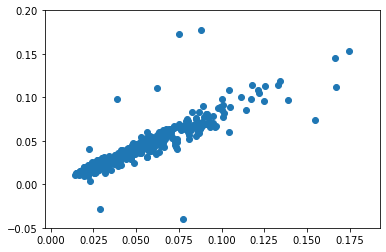

In [35]:
plt.scatter(joined.mwebv_with, joined.c_without- joined.c_with)
plt.ylim(-0.05, .2)

In [44]:
joined.c_without.describe()

count    495.000000
mean       0.025496
std        0.142921
min       -0.997167
25%       -0.051406
50%        0.004655
75%        0.072672
max        0.892803
Name: c_without, dtype: float64

In [45]:
joined.c_with.describe()

count    494.000000
mean       0.043710
std        1.214401
min       -0.259159
25%       -0.086264
50%       -0.032343
75%        0.038832
max       26.825076
Name: c_with, dtype: float64